In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import datetime as dt
import calendar

from Position_Report_Calcs import Position_Reporting

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [5]:
def reporting_date(run_date='today'):
    if run_date=='today':
        current_date = dt.datetime.today().date()
        current_year = current_date.year
    else:
        current_date = run_date
        current_year = current_date.year
    return current_date, current_year
        
current_date, current_year = reporting_date(run_date = dt.datetime.strptime('21-06-2024', '%d-%m-%Y').date())    # for a specific date
#current_date, current_year = reporting_date()    # as at today

In [7]:
## Define the dates we want to use for reporting
#current_date = dt.datetime.today().date()
#current_year = str(dt.datetime.today().date().year)

_, last_day = calendar.monthrange(current_date.year, current_date.month)
end_of_month = dt.date(current_date.year, current_date.month, last_day)

three_months = current_date + dt.timedelta(days=3*30)

six_months = current_date + dt.timedelta(days=6*30)

eoy = '10-12-{}'.format(current_year)
end_of_year = dt.datetime.strptime(eoy, '%d-%m-%Y').date()

one_year = current_date + dt.timedelta(days=365)

end_of_may = dt.datetime.strptime('31-05-2024', '%d-%m-%Y').date()

june = dt.datetime.strptime('15-06-2024', '%d-%m-%Y').date()

end_june = dt.datetime.strptime('28-06-2024', '%d-%m-%Y').date()

end_july = dt.datetime.strptime('31-07-2024', '%d-%m-%Y').date()

end_august = dt.datetime.strptime('30-08-2024', '%d-%m-%Y').date()

sep = dt.datetime.strptime('25-09-2024', '%d-%m-%Y').date()

mid_feb = dt.datetime.strptime('14-02-2025', '%d-%m-%Y').date()

dates_names = ['today','EoM','End of May','June Expiry','End of June', 'End of July', 'End of August', 'Sep Expiry', 'Feb Expiry']
dates_values = [current_date, end_of_month, end_of_may, june, end_june, end_july, end_august, sep, mid_feb]

In [9]:
## Read in the position data
mkts = ['ACCU','NZU','EUA']

positions = dict()
for m in mkts:
    positions[m] = pd.read_excel('Positions.xlsx', sheet_name=m)
    positions[m]['Expiry'] = pd.to_datetime(positions[m].Expiry).dt.date
    positions[m] = positions[m][~((positions[m]['Type'] == 'Option') & (positions[m]['Expiry'] < current_date))] # remove expired options

premiums = pd.read_excel('Positions.xlsx', sheet_name='Index') 

In [11]:
dates = dict()
for i in list(range(0,len(dates_names))):
    dates[dates_names[i]] = dates_values[i]

In [13]:
current_spot = positions['ACCU']
current_spot = current_spot[current_spot.Type=='Spot'].reset_index(drop=True)
current_spot = current_spot['Price'][0]

# ACCU Position Report

In [16]:
accus = dict()

for d in dates_values:
    accus[d] = Position_Reporting(positions, 'ACCU', d).combine_frame()

In [18]:
# data type; 0=PnL, 1=Delta, 2=Option Theta, 3=Option Vega
def generate_summary_plots(mkt_data, data_type):
    if data_type==0:
        colname='Total_Pnl'
    elif data_type==1:
        colname='Total_Delta'
    elif data_type==2:
        colname='Option_Theta'
    elif data_type==3:
        colname='Option_Vega'
    fig = go.Figure()
    for i in list(range(0, len(dates_names))):
        date_value = dates_values[i]
        date_name = dates_names[i]
        fig.add_trace(go.Scatter(x=mkt_data[date_value][data_type].Price, y=mkt_data[date_value][data_type][colname], name=date_name))
    return fig

In [20]:
fig_d = generate_summary_plots(accus, 1)
fig_p = generate_summary_plots(accus, 0)
fig_t = generate_summary_plots(accus,2)
fig_v = generate_summary_plots(accus,3)

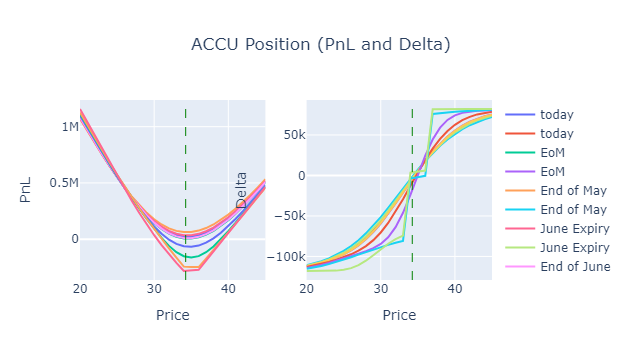

In [22]:
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_d.data)):
    fig.add_trace(fig_p.data[i], row=1, col=1)
    fig.add_trace(fig_d.data[i], row=1, col=2)

fig.update_layout(title={'text': 'ACCU Position (PnL and Delta)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="PnL", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Delta", row=1, col=2)

fig.add_vline(x=current_spot, line_width=1, line_dash="dash", line_color="green")

fig.show()

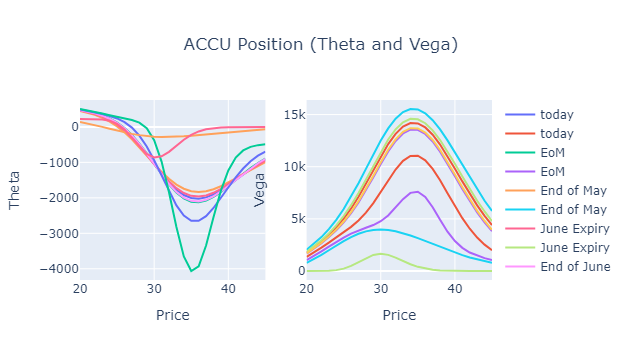

In [24]:
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_d.data)):
    fig.add_trace(fig_t.data[i], row=1, col=1)
    fig.add_trace(fig_v.data[i], row=1, col=2)

fig.update_layout(title={'text': 'ACCU Position (Theta and Vega)','x': 0.5,'xanchor': 'center'})

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Theta", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Vega", row=1, col=2)

fig.show()

# Today's Position

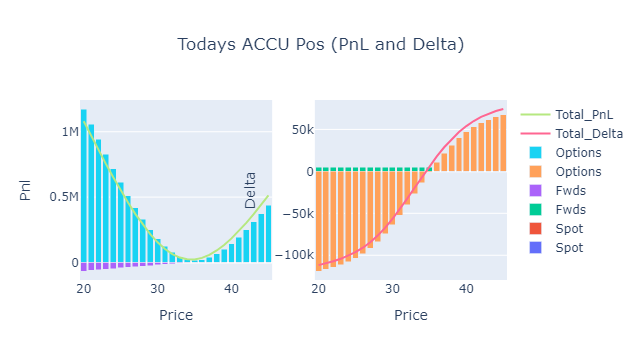

In [27]:
## USE THIS STYLE OF GRAPHING FOR TODAY DATE ENTRY ##
position_functions = Position_Reporting(positions, 'ACCU', current_date)
pnl, delta, theta, vega, value = position_functions.combine_frame()

fig_d = go.Figure()

fig_d.add_trace(go.Bar(x=delta.Price, y=delta.Spot, name='Spot', base=0))
fig_d.add_trace(go.Bar(x=delta.Price, y=delta.Fwds, name='Fwds', base=0))
fig_d.add_trace(go.Bar(x=delta.Price, y=delta.Options, name='Options', base=0))
fig_d.add_trace(go.Scatter(x=delta.Price, y=delta.Total_Delta, mode='lines', name='Total_Delta'))

#fig_d.update_layout(title='ACCU Delta Today', xaxis_title='Price', yaxis_title='Delta', barmode='stack')
#fig_d.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig_p = go.Figure()

fig_p.add_trace(go.Bar(x=pnl.Price, y=pnl.Spot, name='Spot', base=0))
fig_p.add_trace(go.Bar(x=pnl.Price, y=pnl.Fwds, name='Fwds', base=0))
fig_p.add_trace(go.Bar(x=pnl.Price, y=pnl.Options, name='Options', base=0))
fig_p.add_trace(go.Scatter(x=pnl.Price, y=pnl.Total_Pnl, mode='lines', name='Total_PnL'))

#fig_p.update_layout(title='ACCU PnL Today', xaxis_title='Price', yaxis_title='pnl', barmode='stack')
#fig_p.show()


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_d.data)):
    fig.add_trace(fig_d.data[i], row=1, col=2)
    fig.add_trace(fig_p.data[i], row=1, col=1)
    
fig.update_layout(title={'text': 'Todays ACCU Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'}, barmode='stack')

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Pnl", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Delta", row=1, col=2)    
fig.show()  

  # Options Book

In [29]:
p,d,t,v, value = position_functions.options()

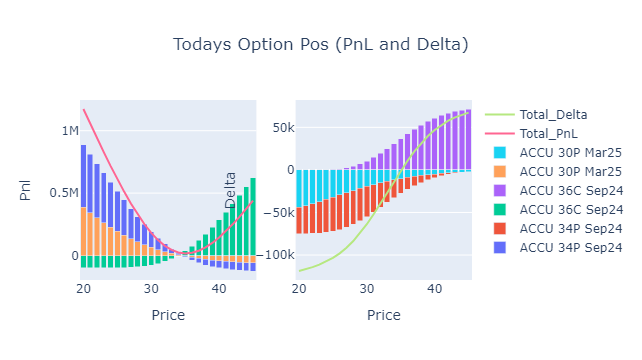

In [32]:
fig_p = go.Figure()
for i in list(p)[1:-1]:
    fig_p.add_trace(go.Bar(x=p.Price, y=p[i], name=i, base=0))

fig_p.add_trace(go.Scatter(x=p.Price, y=p.Option_Pnl, mode='lines', name='Total_PnL'))

#fig_p.update_layout(title='Option PnL Today', xaxis_title='Price', yaxis_title='pnl', barmode='stack')
#fig_p.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig_d = go.Figure()
for i in list(d)[1:-1]:
    fig_d.add_trace(go.Bar(x=d.Price, y=d[i], name=i, base=0))

fig_d.add_trace(go.Scatter(x=d.Price, y=d.Option_Delta, mode='lines', name='Total_Delta'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_p.data)):
    fig.add_trace(fig_p.data[i], row=1, col=1)
    fig.add_trace(fig_d.data[i], row=1, col=2)
    
fig.update_layout(title={'text': 'Todays Option Pos (PnL and Delta)','x': 0.5,'xanchor': 'center'}, barmode='stack')

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Pnl", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Delta", row=1, col=2)    
fig.show()  

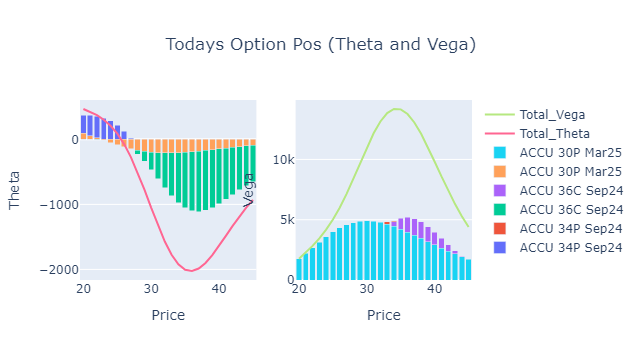

In [34]:
fig_t = go.Figure()
for i in list(t)[1:-1]:
    fig_t.add_trace(go.Bar(x=t.Price, y=t[i], name=i, base=0))

fig_t.add_trace(go.Scatter(x=t.Price, y=t.Option_Theta, mode='lines', name='Total_Theta'))


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig_v = go.Figure()
for i in list(v)[1:-1]:
    fig_v.add_trace(go.Bar(x=v.Price, y=v[i], name=i, base=0))

fig_v.add_trace(go.Scatter(x=v.Price, y=v.Option_Vega, mode='lines', name='Total_Vega'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = make_subplots(rows=1, cols=2)
for i in range(0,len(fig_p.data)):
    fig.add_trace(fig_t.data[i], row=1, col=1)
    fig.add_trace(fig_v.data[i], row=1, col=2)
    
fig.update_layout(title={'text': 'Todays Option Pos (Theta and Vega)','x': 0.5,'xanchor': 'center'}, barmode='stack')

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Theta", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)
fig.update_yaxes(title_text="Vega", row=1, col=2)    
fig.show()  

# Historical Volatility

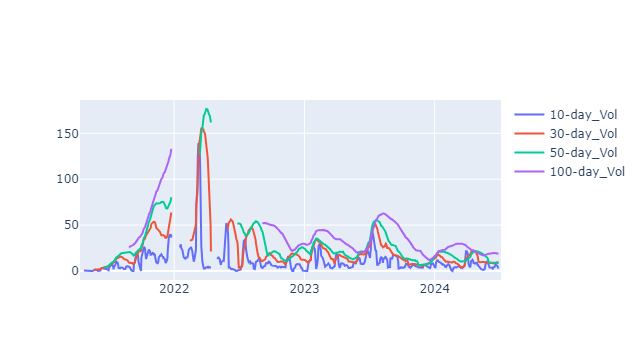

In [37]:
histvol = Position_Reporting(positions, 'ACCU', current_date).rolling_vol()

fig = go.Figure()
for i in list(histvol)[1:]:
    fig.add_trace(go.Scatter(x=histvol['Date'], y=histvol[i], name=i))#, base=0))
    
fig.show()

# Issuances
## Most Recent Issuance